# Klasyfikacja cen telefonów komórkowych
Mikołaj Rozwadowski, 127205

Wybrałem do analizy zbiór danych [Mobile Price Classification](https://www.kaggle.com/iabhishekofficial/mobile-price-classification), zawierający dane na temat różnych modeli telefonów komórkowych, ich specyfikacji technicznej i przedziału cenowego. Etykiety są dyskretne: od 0 (bardzo tanie) do 3 (bardzo drogie), pozostałe atrybuty przyjmują wartości liczbowe lub binarne.
Celem zadania jest zbudowanie klasyfikatora przewidującego, do jakiego przedziału cenowego będzie należał telefon o danych parametrach.

Zbiór został podzielony już przez twórców na część uczącą i testową – odpowiednio po 2000 i 1000 przykładów. Rozpoczynam od wczytania zbioru treningowego do pamięci.

In [2]:
import pandas
import matplotlib.pyplot as plt
import math
import numpy as np

train_file = 'data/train.csv'
df = pandas.read_csv(train_file)

print(df.columns)
print()
print(df.head())

numeric_attrs = {
    'battery_power': 'Pojemność baterii [mAh]',
    'clock_speed': 'Taktowanie procesora [GHz]',
    'fc': 'Rozdzielczość przedniego aparatu [Mpix]',
    'int_memory': 'Pamięć wewnętrzna [GB]',
    'm_dep': 'Głębokość [cm]',
    'mobile_wt': 'Waga [g]',
    'n_cores': 'Liczba rdzeni procesora',
    'pc': 'Rozdzielczość głównego aparatu [Mpix]',
    'px_height': 'Długość ekranu [pix]',
    'px_width': 'Szerokość ekranu [pix]',
    'ram': 'Pamięć RAM [MB]',
    'sc_h': 'Długość ekranu [cm]',
    'sc_w': 'Szerokość ekranu [cm]',
    'talk_time': 'Czas rozmowy na jednym ładowaniu [h]',
}

boolean_attrs = {
    'blue': 'Bluetooth',
    'dual_sim': 'Dual SIM',
    'four_g': '4G',
    'three_g': '3G',
    'touch_screen': 'Ekran dotykowy',
    'wifi': 'Wi-Fi'
}

labels = sorted(df.price_range.unique())

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          

Na początek wyświetlijmy histogramy cech numerycznych:

In [3]:
cols = 4
rows = math.ceil(len(numeric_attrs) / cols)

plt.subplots_adjust(hspace=0.8)
fig = plt.figure(figsize=(200, 100))
for i, (key, label) in enumerate(numeric_attrs.items(), 1):
    ax = fig.add_subplot(rows, cols, i)
    ax.title.set_text(label)
    ax.hist(df[key])
plt.show()

<Figure size 432x288 with 0 Axes>

Większość cech ma rozkład zbliżony do jednostajnego, choć w przypadku rozdzielczości przedniego aparatu, długości ekranu w piselach i szerokości ekranu w centymetrach można zauważyć, że wysokie wartości występują rzadziej.

Sprawdźmy teraz, jak wygląda rozkład z podziałem na klasy:

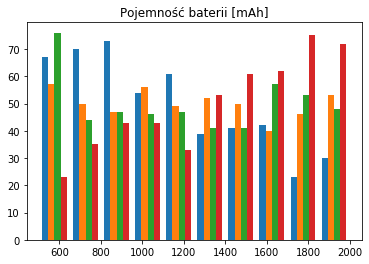

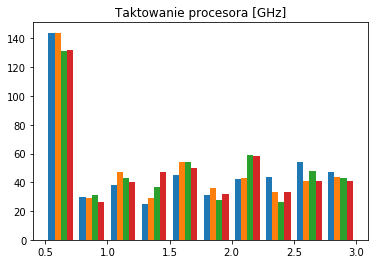

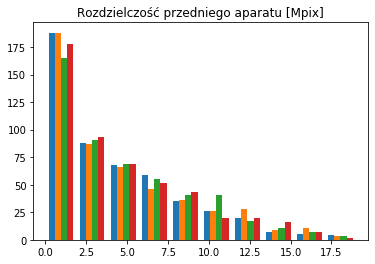

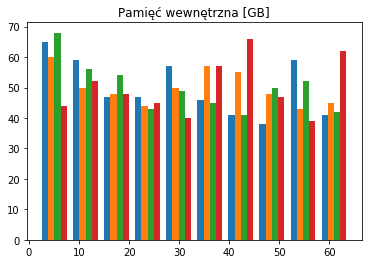

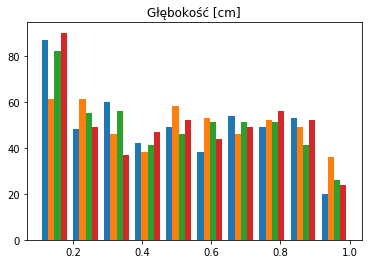

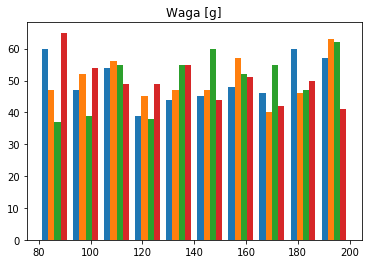

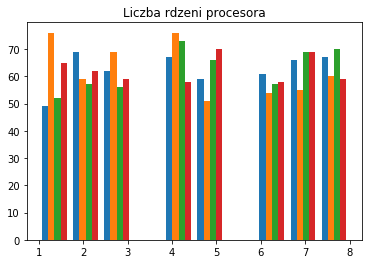

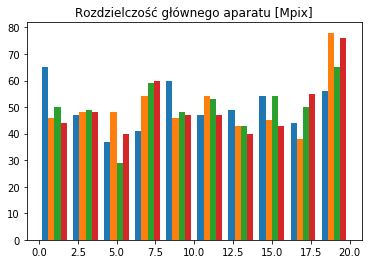

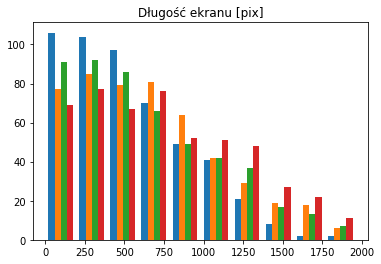

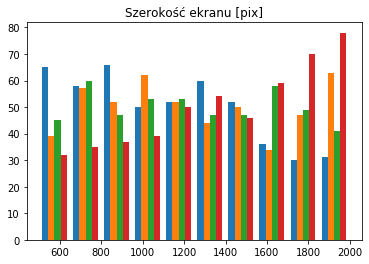

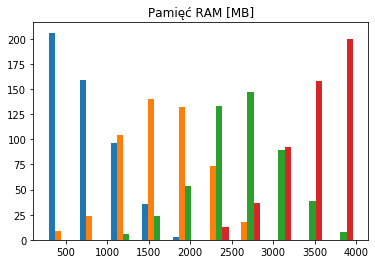

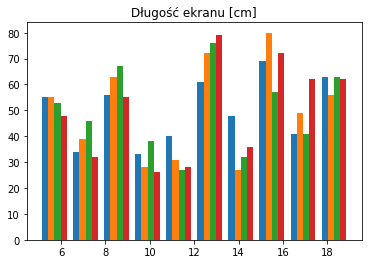

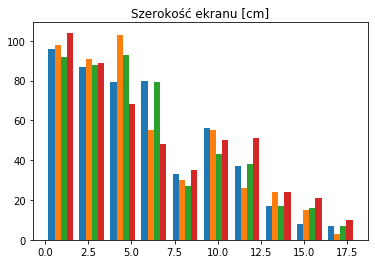

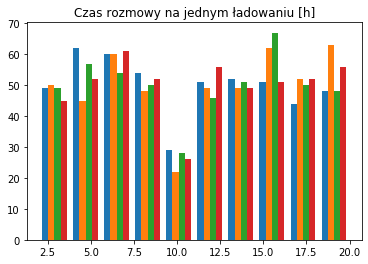

In [4]:
for (key, label) in numeric_attrs.items():
    subset = [df[df.price_range == label][key] for label in labels]
    plt.title(label)
    plt.hist(subset, histtype='bar')
    plt.show()

Interesująco wygląda histogram pamięci RAM – widać, że parametr ten częściej jest wyższy w droższych modelach. Można się spodziewać, że ten atrybut będzie mocno dyskryminujący.

Przeanalizujmy teraz atrybuty binarne:

In [5]:
table = np.zeros((len(boolean_attrs), len(labels)))

keys = list(boolean_attrs.keys())
for j, label in enumerate(labels):
    total = len(df[df.price_range == label])
    for i, key in enumerate(keys):
        count = len(df[(df.price_range == label) & (df[key] == True)])
        table[i, j] = count / total

pandas.DataFrame(table, index=[boolean_attrs[key] for key in keys])

,0,1,2,3
Bluetooth,0.486,0.490,0.486,0.518
Dual SIM,0.500,0.510,0.498,0.530
4G,0.518,0.524,0.494,0.550
3G,0.746,0.756,0.774,0.770
Ekran dotykowy,0.524,0.522,0.470,0.496
Wi-Fi,0.496,0.504,0.504,0.524


Okazuje się, że prawdopodobieństwa wystąpienia tych cech są bardzo zbliżone we wszystkich kategoriach cenowych.

In [22]:
# plt.scatter(df.battery_power, (df.sc_h * df.sc_w))
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pca = PCA()
pca.fit(df)
print(pca.explained_variance_ratio_)

lda = LDA()
X = df.values[:, :-2]
y = df.values[:, -1]
# print(data)
lda.fit(X, y)
lda.coef_
# print(lda.explained_variance_ratio_)

[6.70439532e-01 1.65179038e-01 1.10061545e-01 5.33449230e-02
 7.14285114e-04 1.87074345e-04 2.66769330e-05 1.70428313e-05
 1.55698367e-05 5.21610630e-06 4.83661712e-06 2.96547697e-06
 3.80148409e-07 1.94461592e-07 1.47059323e-07 1.44285632e-07
 1.42274397e-07 1.32503316e-07 5.80438732e-08 4.90212661e-08
 4.69319804e-08]


array([[-7.69269685e-03,  2.94803604e-02,  2.16912859e-01,
         3.46964876e-01, -1.73397626e-02,  1.32246204e-02,
        -1.32360262e-02, -5.07174727e-02,  1.29416319e-02,
         1.38687091e-03, -2.04037416e-03, -4.29540902e-03,
        -4.19379827e-03, -1.41678379e-02, -1.41097598e-02,
         1.19638589e-02, -1.67361495e-02, -4.07978408e-01,
         6.32764111e-02],
       [-2.20631700e-03,  6.79681269e-03,  4.15940652e-03,
         1.36514650e-01, -3.18991754e-04,  2.66408041e-02,
        -2.95876060e-03,  2.68960405e-01,  3.89537554e-03,
        -4.61783326e-02, -1.84155477e-04, -1.03819072e-03,
        -1.22768148e-03, -4.30823423e-03, -5.68092768e-03,
        -5.59904154e-03,  1.05584252e-02, -1.30632089e-01,
         7.24828625e-02],
       [ 2.06002201e-03, -5.42463249e-02, -4.40623731e-02,
        -1.74038471e-01,  1.47514570e-02, -1.87202252e-01,
        -5.68706801e-06, -1.41463189e-01, -1.19596948e-03,
         3.50515787e-02, -4.17885727e-03,  1.17332517e-03,
    